## For 30 second interval

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

df = pd.read_csv('processed_data/train_data.csv')
pd.set_option('display.max_rows', 500)

In [2]:
#df.head(10)

In [3]:
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        indices = np.argsort(importance)
        
        # Get top 10 and bottom 10 feature indices
        selected_indices = np.concatenate((indices[:10], indices[-10:]))
        selected_importances = importance[selected_indices]
        selected_features = np.array(feature_names)[selected_indices]
        
        # Sort selected features by importance
        sorted_indices = np.argsort(selected_importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance: {model_name}')
        plt.bar(range(20), selected_importances[sorted_indices], align='center')
        plt.xticks(range(20), selected_features[sorted_indices], rotation=90)
        plt.xlim([-1, 20])
        plt.show()
    else:
        print(f"Model {model_name} does not have feature_importances_ attribute")

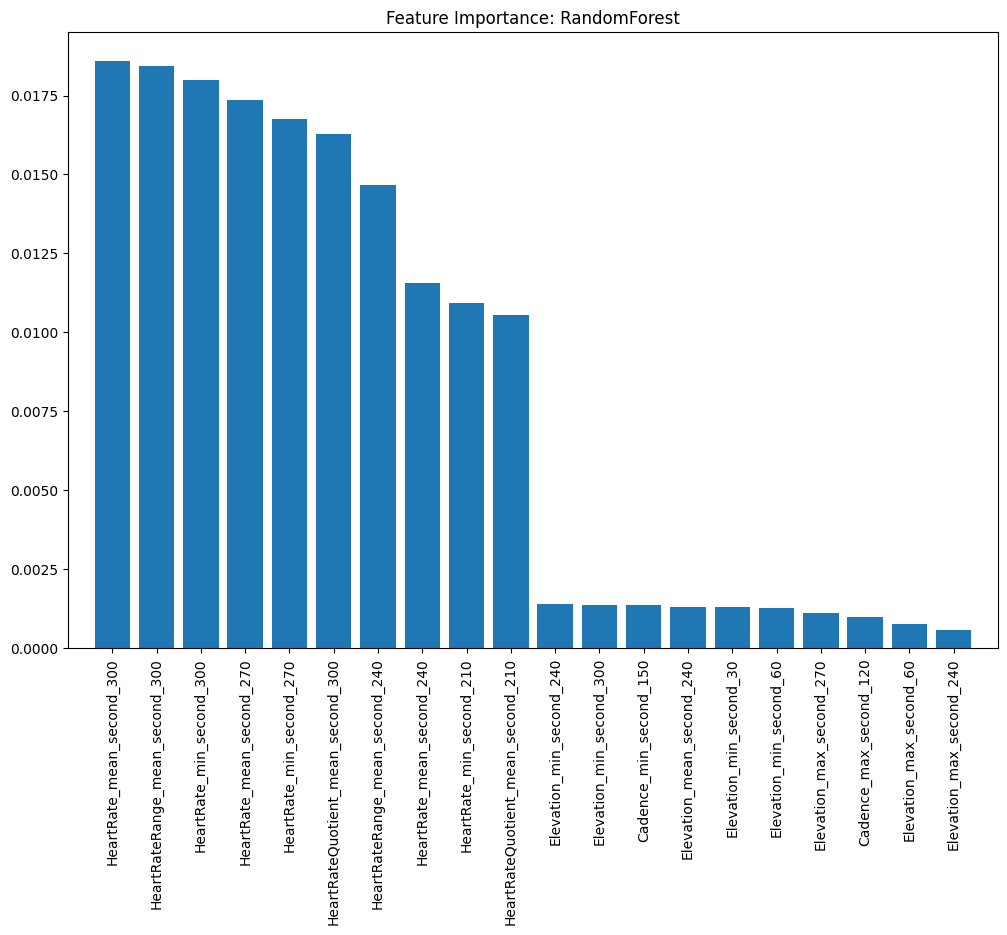

Classifier: RandomForest
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.49019607843137253
CV Mean Accuracy: 0.4534146341463415
95% CI: (0.42535883133504987, 0.4814704369576331)
Classification Report:
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         1
         5.0       0.50      0.17      0.25         6
         6.0       0.50      0.29      0.36         7
         7.0       0.53      0.90      0.67        20
         8.0       0.36      0.29      0.32        14
         9.0       0.00      0.00      0.00         3

    accuracy                           0.49        51
   macro avg       0.32      0.27      0.27        51
weighted avg       0.43      0.49      0.43        51





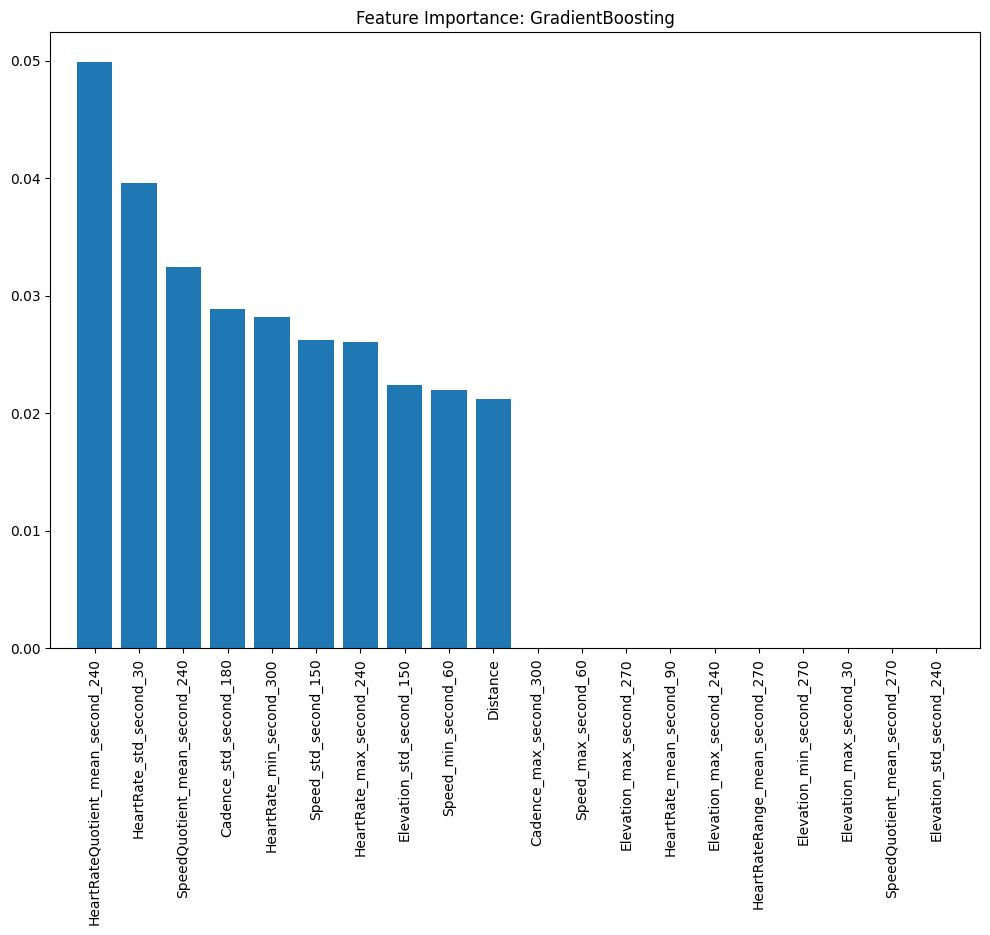

Classifier: GradientBoosting
Best Params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.4117647058823529
CV Mean Accuracy: 0.37390243902439024
95% CI: (0.32315896271595856, 0.4246459153328219)
Classification Report:
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         1
         5.0       0.20      0.17      0.18         6
         6.0       0.40      0.29      0.33         7
         7.0       0.48      0.65      0.55        20
         8.0       0.38      0.36      0.37        14
         9.0       0.00      0.00      0.00         3

    accuracy                           0.41        51
   macro avg       0.24      0.24      0.24        51
weighted avg       0.37      0.41      0.39        51



Model SVC does not have feature_importances_ attribute
Classifier: SVC
Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.49019607843137253
CV Mean Accuracy: 0.4390243902439025
95% CI: (0.387095

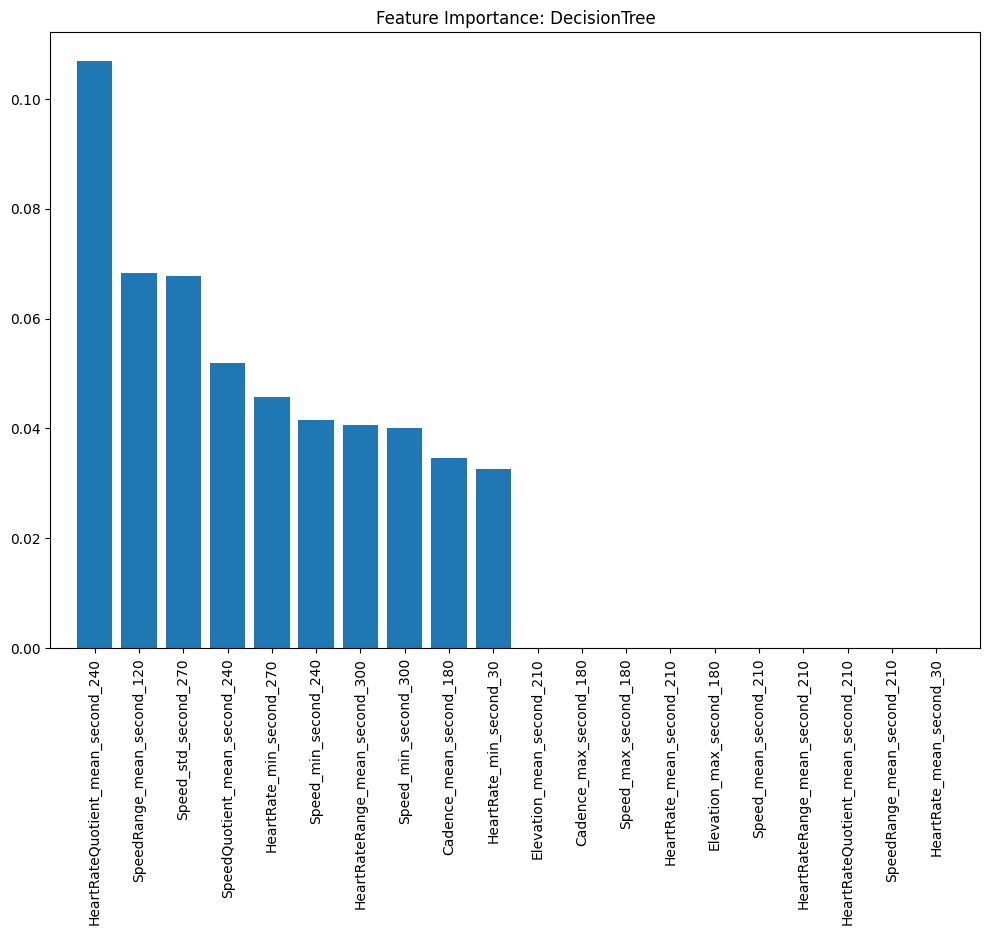

Classifier: DecisionTree
Best Params: {'max_depth': None, 'min_samples_split': 10}
Accuracy: 0.4117647058823529
CV Mean Accuracy: 0.3308536585365854
95% CI: (0.2589588726977292, 0.40274844437544155)
Classification Report:
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         1
         5.0       0.33      0.50      0.40         6
         6.0       0.40      0.29      0.33         7
         7.0       0.48      0.50      0.49        20
         8.0       0.40      0.43      0.41        14
         9.0       0.00      0.00      0.00         3

    accuracy                           0.41        51
   macro avg       0.27      0.29      0.27        51
weighted avg       0.39      0.41      0.40        51



Model NaiveBayes does not have feature_importances_ attribute
Classifier: NaiveBayes
Best Params: {'var_smoothing': 1e-09}
Accuracy: 0.19607843137254902
CV Mean Accuracy: 0.31085365853658536
95% CI: (0.2619728493063225, 0.35973446776

In [4]:
X = df.drop(['Label', 'RunID'], axis=1)
y = df['Label']

# Remove classes with fewer than 2 instances
y = y[y.map(y.value_counts()) >= 2]
X = X.loc[y.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the classifiers and their reduced hyperparameter grids
classifiers = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 10]
    }),
    'GradientBoosting': (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 7]
    }),
    'SVC': (SVC(), {
        'C': [0.1, 1],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 7],
        'weights': ['uniform', 'distance']
    }),
    'DecisionTree': (DecisionTreeClassifier(), {
        'max_depth': [None, 10],
        'min_samples_split': [2, 10]
    }),
    'NaiveBayes': (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8]
    })
}

# Dictionary to store the best models and their results
best_models = {}
results = []

# Function to calculate 95% confidence intervals
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = np.std(data) / np.sqrt(len(data))
    margin = sem * 1.96  # for 95% confidence
    return mean, mean - margin, mean + margin

# Perform hyperparameter tuning and evaluation for each classifier
for clf_name, (clf, param_grid) in classifiers.items():
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    # Plot feature importance using the best model from GridSearchCV
    plot_feature_importance(best_model, clf_name, X.columns)
    
    # Get cross-validated accuracy scores
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score, ci_lower, ci_upper = confidence_interval(cv_scores)
    
    best_models[clf_name] = best_model
    results.append({
        'Classifier': clf_name,
        'Best Params': grid_search.best_params_,
        'Accuracy': accuracy,
        'CV Mean Accuracy': mean_cv_score,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'Classification Report': report
    })
    print(f"Classifier: {clf_name}")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"CV Mean Accuracy: {mean_cv_score}")
    print(f"95% CI: ({ci_lower}, {ci_upper})")
    print("Classification Report:")
    print(report)
    print("\n" + "="*80 + "\n")

# Displaying the summary of results
results_df = pd.DataFrame(results)
print(results_df)
